In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

c:\anaconda3\envs\py36tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load example Data 
mnist = input_data.read_data_sets('MNIST-data', one_hot=True,reshape=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
#define  inital Weight and Bias function
def weightVariable(shapeW):
    init = tf.truncated_normal(shape=shapeW,stddev=0.1)
    return tf.Variable(initial_value=init)

def biasVariable(shapeB):
    init = tf.constant(0.5,shape=shapeB)
    return tf.Variable(initial_value=init)

In [4]:
#define convolution Function 
def con2D(inputX,weightF,strite_num = 1):
    # tf.nn.conv2d( input, filter, strides, padding, use_cudnn_on_gpu=True,
    #               data_format='NHWC', dilations=[1, 1, 1, 1], name=None)
    # NHWC mean => [batch, height, width, channels]
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(input=inputX,filter=weightF,
                        strides=[1,strite_num,strite_num,1],padding="SAME")

In [5]:
#define Maxpool Function
def maxPool(inputX,size=2,strite_num = 2):
    # tf.nn.max_pool(value,ksize,strides,padding,data_format='NHWC',name=None)
    return tf.nn.max_pool(value=inputX,ksize=[1,size,size,1],
                          strides=[1,strite_num,strite_num,1],padding="SAME")

# Create Neural Network

In [6]:
#create placeholder xs and ys , xs is an image input and ys is a label of class
#[optional]reshape for make sure the input is 28*28
tf.reset_default_graph()   # clear all graph

xs = tf.placeholder(shape=[None,28,28,1],dtype=tf.float32,name="inputX")
ys = tf.placeholder(shape=[None,10],dtype=tf.float32,name="labelY")
xImage = tf.reshape(xs,[-1,28,28,1])

In [7]:
#conv1
numFilter_1 = 32
filter_con1 = weightVariable([5,5,1,numFilter_1]) # patch 5x5, in size 1, out size 32
bias_con1 = biasVariable([numFilter_1])
feature_con1 = tf.nn.bias_add(con2D(inputX=xImage,weightF=filter_con1,strite_num=1),bias_con1)
feature_con1 = tf.nn.relu(feature_con1)   #relu Activation

In [8]:
#Maxpool1
pool1 = maxPool(feature_con1)

In [9]:
#conv2
numFilter_2 = 64
filter_con2 = weightVariable([5,5,numFilter_1,numFilter_2])
bias_con2 = biasVariable([numFilter_2])
feature_con2 = tf.nn.bias_add(con2D(inputX=pool1,weightF=filter_con2,strite_num=1),bias_con2)
feature_con2 = tf.nn.relu(feature_con2) #relu Activation

In [10]:
#Maxpool2
pool2 = maxPool(inputX=feature_con2)

In [11]:
#FullyConnected    #3136->512->512->10
layer_shape = pool2.get_shape()
TotalElement = layer_shape[1:4].num_elements()
print("ToTal Element = {:d}".format(TotalElement))

ToTal Element = 3136


In [12]:
FFconnect = tf.reshape(pool2,[-1,TotalElement])
wF1 = weightVariable(shapeW=[TotalElement,512])
bF1 = biasVariable(shapeB=[512])
FF_feature_1 = tf.matmul(FFconnect,wF1)+bF1
FF_feature_1 = tf.nn.relu(FF_feature_1)

In [13]:
wF2 = weightVariable(shapeW=[512,10])
bF2 = biasVariable(shapeB=[10])
FF_feature_2 = tf.matmul(FF_feature_1,wF2)+bF2

prediction_out = tf.nn.softmax(FF_feature_2,name="Y_pre")

define cross entropy
$$H_{y'}(y) = - \sum_{i}  y'_i \times log(y_i)$$

In [14]:
cost =tf.reduce_mean(-tf.reduce_sum(ys*tf.log(prediction_out),reduction_indices=1),name="cost")
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)   

In [15]:
#create accuracy tensor
y_predic_cls = tf.argmax(prediction_out,axis=1)
y_true_cls = tf.argmax(ys, axis=1)
correct_prediction = tf.equal(y_predic_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")

In [16]:
# save Information
tf.summary.scalar('cross_entropy', cost)
tf.summary.scalar('accuracy', accuracy)
summary_op = tf.summary.merge_all()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()


In [27]:

sess = tf.Session()
initValue = tf.global_variables_initializer()
sess.run(initValue)
train_summary_file = tf.summary.FileWriter("Log/train",graph=sess.graph)
test_summary_file  = tf.summary.FileWriter("Log/test",graph=sess.graph)
#training section

acc_val = 0
for i in range(300):
    batch_xs, batch_ys = mnist.train.next_batch(100)  #get data from mnist 
    _,summary_out  = sess.run([optimizer,summary_op], feed_dict={xs: batch_xs, ys: batch_ys})  #feed data to tensorflow  we have 2 branch optimizer and summary_op
    train_summary_file.add_summary(summary_out,i)  #save train_summary
    if i % 100 == 0:
        # success ?
        ta, tc = sess.run([accuracy, cost], feed_dict={xs: batch_xs, ys: batch_ys})    #feed train data to tensor fro accuracy and cost
        test_data = {xs: mnist.test.images, ys: mnist.test.labels}                             # get new data mnist for test
        va, vc, summary_test = sess.run([accuracy, cost, summary_op], feed_dict=test_data)                   #feed test data to tensor for acc and cost
        print("Step : %d Batch : acc = %.4f loss = %.4f | Test acc = %.4f loss = %.4f" % (i, ta, tc, va, vc))   #print imformation
        test_summary_file.add_summary(summary_test,i)
        if va > acc_val:

            # Save the variables to disk.
            save_path = saver.save(sess, "./tmp/bestACC")
            print("Model saved improve from: {:f}  to {:f}".format(acc_val,va))
            acc_val  = va


Step : 0 Batch : acc = 0.1000 loss = 5.3227 | Test acc = 0.0773 loss = 5.9389
Model saved improve from: 0.000000  to 0.077300
Step : 100 Batch : acc = 0.7700 loss = 0.7537 | Test acc = 0.7623 loss = 0.7787
Model saved improve from: 0.077300  to 0.762300
Step : 200 Batch : acc = 0.8300 loss = 0.5530 | Test acc = 0.8557 loss = 0.4759
Model saved improve from: 0.762300  to 0.855700


# Restore Graph and weight

In [29]:
# delete the current graph
tf.reset_default_graph()

# import the graph from the file
imported_graph = tf.train.import_meta_graph('./tmp/bestACC.meta')
# list all the tensors in the graph
with tf.Session() as sess:
    initValue = tf.global_variables_initializer()
    sess.run(initValue)
    imported_graph.restore(sess, './tmp/bestACC')
    test_data = {"inputX:0":mnist.test.images,"labelY:0":mnist.test.labels}
    a = sess.run(["ACC:0"],feed_dict=test_data)
    print("Step : %d Batch : Test acc = {:2.4f}".format(a[0]))   #print information

INFO:tensorflow:Restoring parameters from ./tmp/bestACC
Step : %d Batch : Test acc = 0.9097


INFO:tensorflow:Restoring parameters from ./tmp/bestACC


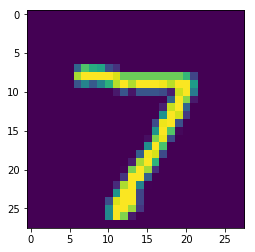

[array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)]
[7]


In [32]:
with tf.Session() as sess:
    imported_graph.restore(sess, './tmp/bestACC')
    image = mnist.test.images[0]*255
    image = np.reshape(image,[28,28])
    plt.imshow(image)
    plt.show()
    
    
    image = np.reshape(image,[-1,28,28,1])
    a = sess.run(["Y_pre:0"],feed_dict= {"inputX:0":image})
    print(a)
    print(np.argmax(a[0],axis=1))
